### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings 
import sys
import pdb, os
import matplotlib.pyplot as plt
from scipy import misc
import scipy.ndimage as ndimage
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imageio
from scipy import linalg
import scipy.ndimage as ndi
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from torch.utils.data.sampler import SubsetRandomSampler

### **Loading The Data**

In [ ]:
! mkdir ~/.kaggle

!mv kaggle.json /root/.kaggle
!kaggle datasets download -d espsiyam/nuclei-image-segmentation

100% 89.4M/89.4M [00:00<00:00, 150MB/s]



### **Unzipping The Data**

In [ ]:
# Extract Dataset
!unzip nuclei-image-segmentation.zip
!ls U-NET

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
Data_PATH = './U_NET/train/'
data_ids = os.listdir(Data_PATH)

### **Data Preprocessing**

In [ ]:
print('Getting and resizing training images ... ')
X_data = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_data = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 256 x 256
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in enumerate(data_ids):
    path = Data_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_data[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in os.listdir(path + '/masks/'):
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_data[n] = mask

Getting and resizing training images ... 


### **Data Visualization**

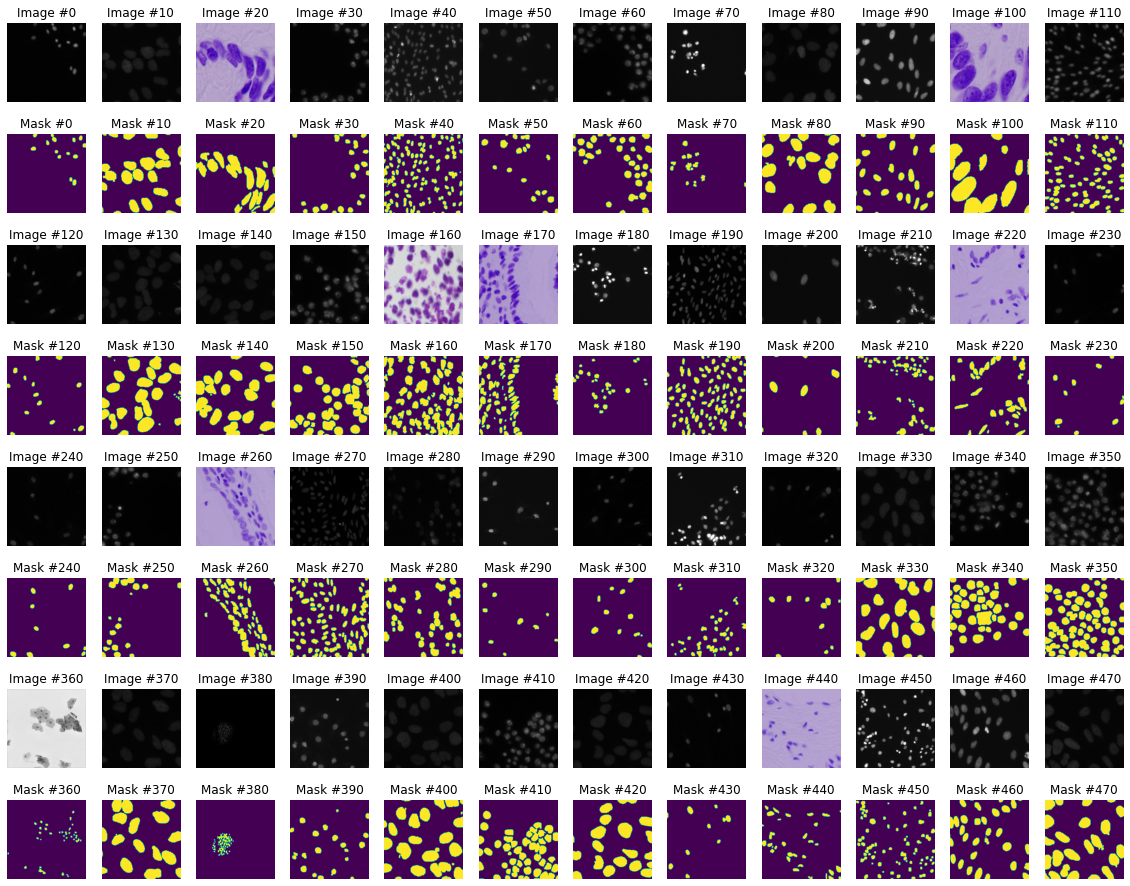

In [ ]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_data[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_data[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

### **Checking Cuda Availibility**

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA not available')
else:
    print('CUDA is available')

CUDA is available


### **Custom Dataloader**

In [ ]:
class NucleiDataset(Dataset):
    """Cell Detection dataset """

    def __init__(self, data_path = './U_NET/train/', augment=False):
        self.img_width = 256
        self.img_height = 256
        self.img_channels = 3
        self.data_path = data_path
        self.data_ids = os.listdir(data_path)        
        self.augment = augment

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):  
        id_ = self.data_ids[idx]                
        path = self.data_path + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:self.img_channels]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X = np.asarray(img, dtype = 'float32')
    
        mask = np.zeros((self.img_height, self.img_width, 1), dtype=np.bool)
        for mask_file in os.listdir(path + '/masks/'):
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_).astype('bool')
        Y = np.asarray(mask, dtype = 'float32')
        
        X = torch.from_numpy(X).permute(2, 0, 1)
        Y = torch.from_numpy(Y).permute(2, 0, 1)
        return X, Y

### **Spliting Data- Train, Validation, Test** 

In [ ]:
valid_size = 0.22
test_size = 0.2

My_DATA = NucleiDataset()

indices = list(range(len(My_DATA)))
np.random.shuffle(indices)
split = int(np.floor(test_size * len(My_DATA)))
test_idx , t_v_idx = indices[:split] , indices[split:]

indices = list(range(len(t_v_idx)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(t_v_idx)))
valid_idx , train_idx = indices[:split] , indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(My_DATA, batch_size = 10, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(My_DATA, batch_size = 10, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(My_DATA, batch_size = 10, sampler = test_sampler)

### **Model Architechture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class U_net_base(nn.Module):
    def __init__(self):
        super(U_net_base, self).__init__()
        self.sigmoid_layer = nn.Sigmoid()
        
        ## encoder layers ##
        self.block1A = nn.Conv2d(3, 32, 3, padding=1, bias = False)
        self.bn1A = nn.BatchNorm2d(32)
        self.block1B = nn.Conv2d(32, 32, 3, padding=1, bias = False)
        self.bn1B = nn.BatchNorm2d(32)

        self.block2A = nn.Conv2d(32, 64, 3, padding=1, bias = False)  
        self.bn2A = nn.BatchNorm2d(64)
        self.block2B = nn.Conv2d(64, 64, 3, padding=1, bias = False)  
        self.bn2B = nn.BatchNorm2d(64)

        self.block3A = nn.Conv2d(64, 128, 3, padding=1, bias = False)  
        self.bn3A = nn.BatchNorm2d(128)
        self.block3B = nn.Conv2d(128, 128, 3, padding=1, bias = False)  
        self.bn3B = nn.BatchNorm2d(128)
        
        self.block4 = nn.Conv2d(128, 512, 3, padding=1, bias = False)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv5A = nn.Conv2d(512+128, 128, 3, padding=1, bias=False)
        self.bn5A = nn.BatchNorm2d(128)
        self.conv5B = nn.Conv2d(128, 128, 3, padding=1, bias=False)
        self.bn5B = nn.BatchNorm2d(128)
        
        self.conv6A = nn.Conv2d(128+64, 64, 3, padding=1, bias=False)
        self.bn6A = nn.BatchNorm2d(64)
        self.conv6B = nn.Conv2d(64, 64, 3, padding=1, bias=False)
        self.bn6B = nn.BatchNorm2d(64)
        
        self.conv7A = nn.Conv2d(64+32, 32, 3, padding=1, bias=False)
        self.bn7A = nn.BatchNorm2d(32)
        self.conv7B = nn.Conv2d(32, 32, 3, padding=1, bias=False)
        self.bn7B = nn.BatchNorm2d(32)
        
        # prediction layer
        self.pred = nn.Conv2d(32, 1, 1, padding=0, bias=False)

    def forward(self, x):
        # Encoder
        # block 1
        block1 = F.relu(self.bn1A(self.block1A(x)))
        pool1 = self.pool(F.relu(self.bn1B(self.block1B(block1))))
        # block 2
        block2 = F.relu(self.bn2A(self.block2A(pool1)))
        pool2 = self.pool(F.relu(self.bn2B(self.block2B(block2))))
        # block 3
        block3 = F.relu(self.bn3A(self.block3A(pool2)))
        pool3 = self.pool(F.relu(self.bn3B(self.block3B(block3))))
        # block 4
        block4 = F.relu(self.bn4(self.block4(pool3)))
        
        ## Decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        up4_ = F.interpolate(block4, scale_factor=2, mode='nearest')
        up4 = torch.cat((up4_, block3), 1)
        x = F.relu(self.bn5A(self.conv5A(up4)))
        block5 = F.relu(self.bn5B(self.conv5B(x)))
        # upsample again, output should have a sigmoid applied
        up5_ = F.interpolate(block5, scale_factor=2, mode='nearest')
        up5 = torch.cat((up5_, block2), 1)
        x = F.relu(self.bn6A(self.conv6A(up5)))
        block6 = F.relu(self.bn6B(self.conv6B(x)))
        # upsample again, output should have a sigmoid applied
        up6_ = F.interpolate(block6, scale_factor=2, mode='nearest')
        up6 = torch.cat((up6_, block1), 1)
        x = F.relu(self.bn7A(self.conv7A(up6)))
        block7 = F.relu(self.bn7B(self.conv7B(x)))
        pred_layer = self.sigmoid_layer(self.pred(block7))
        return pred_layer

# initialize the NN
model = U_net_base()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data)

model.apply(weights_init)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(model)
if train_on_gpu:
    # model.cuda()
    model.to(device)

U_net_base(
  (sigmoid_layer): Sigmoid()
  (block1A): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1A): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1B): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1B): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2A): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2A): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2B): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2B): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block3A): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3A): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block3B): Conv2d(128, 128, kernel_size=(3, 3), str

### **Loss Function**

In [ ]:
def dice(y_true, y_hat):
  return 1 - ((2 * (y_true * y_hat).sum() + 1e-15) / (y_true.sum() + y_hat.sum() + 1e-15))


### **Optimizer**

In [ ]:
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **Training**

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
valid_loss_list = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = dice(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = dice(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.493955 	Validation Loss: 0.425230
Validation loss decreased (inf --> 0.425230).  Saving model ...
Epoch: 2 	Training Loss: 0.348104 	Validation Loss: 0.240540
Validation loss decreased (0.425230 --> 0.240540).  Saving model ...
Epoch: 3 	Training Loss: 0.259865 	Validation Loss: 0.270428
Epoch: 4 	Training Loss: 0.228987 	Validation Loss: 0.151336
Validation loss decreased (0.240540 --> 0.151336).  Saving model ...
Epoch: 5 	Training Loss: 0.175361 	Validation Loss: 0.132777
Validation loss decreased (0.151336 --> 0.132777).  Saving model ...
Epoch: 6 	Training Loss: 0.150125 	Validation Loss: 0.113329
Validation loss decreased (0.132777 --> 0.113329).  Saving model ...
Epoch: 7 	Training Loss: 0.133659 	Validation Loss: 0.109246
Validation loss decreased (0.113329 --> 0.109246).  Saving model ...
Epoch: 8 	Training Loss: 0.119519 	Validation Loss: 0.095911
Validation loss decreased (0.109246 --> 0.095911).  Saving model ...
Epoch: 9 	Training Loss: 0.111834 

### **Loss Function Plot**

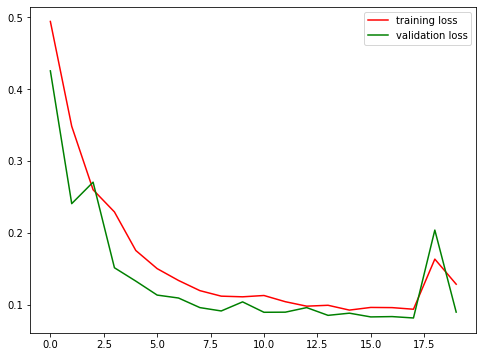

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_loss_list ,color='red' ,label='training loss')
plt.plot(valid_loss_list,color='green' ,label = 'validation loss')
plt.legend()

In [ ]:
model.load_state_dict(torch.load('/content/model_augmented.pt'))
model.eval()

U_net_base(
  (sigmoid_layer): Sigmoid()
  (block1A): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1A): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1B): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1B): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2A): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2A): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2B): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2B): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block3A): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3A): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block3B): Conv2d(128, 128, kernel_size=(3, 3), str

### **Testing The Data**

In [ ]:
# track test loss 
# over 5 flower classes
test_loss = 0.0

model.eval() # eval mode
data_list = []
output_list = []
target_list = []

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = dice(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    for i in range(data.size(0)):
      data_list.append(np.transpose(data[i].cpu().detach().numpy().astype(int),(1,2,0)).copy())
      output_list.append(np.squeeze(np.transpose(output[i].cpu().detach().numpy().astype(int),(1,2,0))).copy())
      target_list.append(np.squeeze(np.transpose(target[i].cpu().detach().numpy().astype(int),(1,2,0))).copy())
    

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# calculate Accuracy
print('\nTest Accuracy (Overall): ', 100 * (1-test_loss),'%')

Test Loss: 0.017689


Test Accuracy (Overall):  98.23106216386472 %


### **Vizualize The Result**

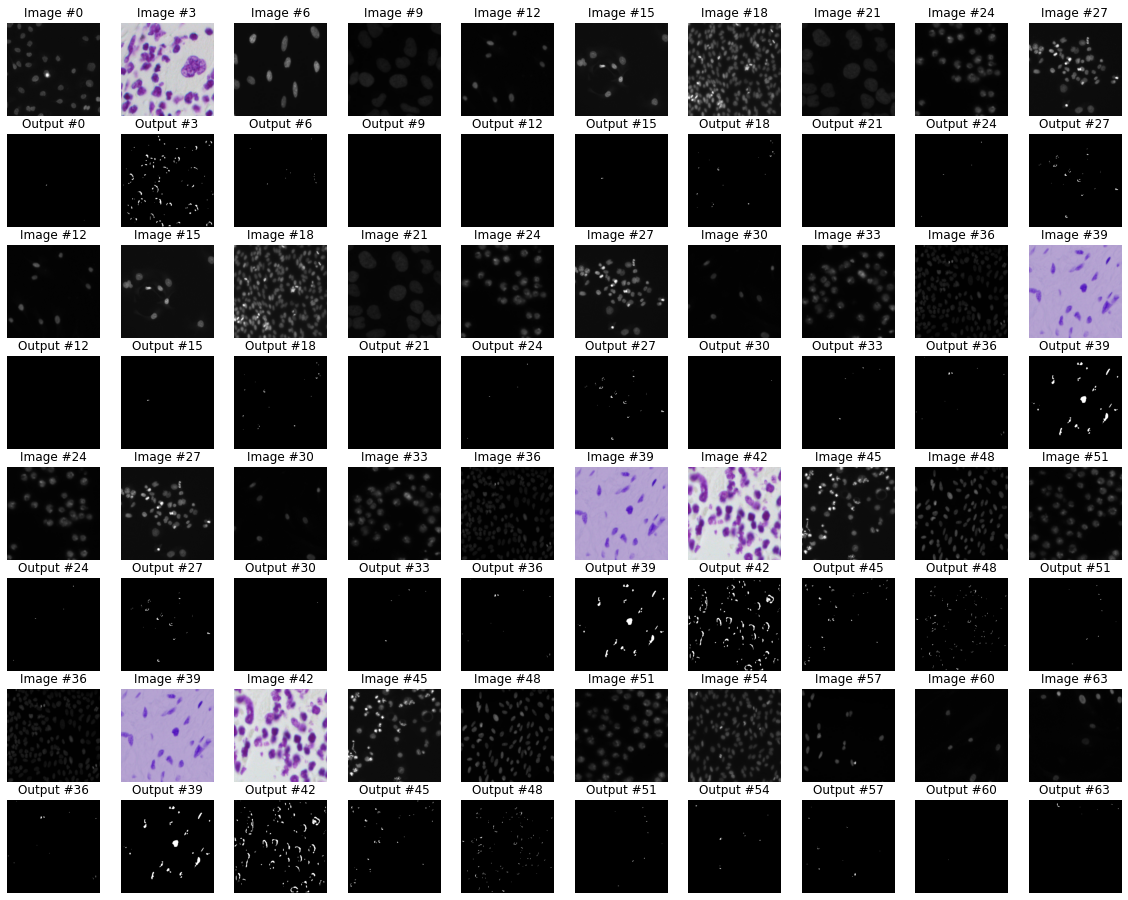

In [ ]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 10,4
for i in range(y):  
  for j in range(x):
    plt.subplot(y*2, x, i*2*x+j+1)
    pos = i*12 + j*3
    plt.imshow(data_list[pos])
    plt.title('Image #{}'.format(pos))
    plt.axis('off')
    plt.subplot(y*2, x, (i*2+1)*x+j+1)
    
    #We display the associated mask we just generated above with the training image
    plt.imshow(output_list[pos],cmap='gray')
    plt.title('Output #{}'.format(pos))
    plt.axis('off')
        
plt.show()